In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import qutip as qt
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm)
import lattpy as lp
from scipy.optimize import curve_fit
from scipy.linalg import expm
import matplotlib.patches as patches




d/lambda0= 5e-06 [-2.12775192e+01 -2.05086589e+00 -6.94417722e-01 -3.36962467e-01
 -1.94226257e-01 -1.23722940e-01 -8.40458207e-02 -5.96532249e-02
 -4.36692980e-02 -3.26795675e-02 -2.48361778e-02 -1.90703433e-02
 -1.47300729e-02 -1.14001320e-02 -8.80637806e-03 -6.76245533e-03
 -5.13830849e-03 -3.84148579e-03 -2.80502004e-03 -1.97995987e-03
 -1.33011452e-03 -8.28935985e-04 -4.56925927e-04 -2.00304724e-04
 -4.97797176e-05 -4.76610550e-07 -2.84691493e-07 -2.20284951e-07
 -1.94518638e-07 -1.92212879e-07 -1.86148458e-07 -1.70543866e-07
 -1.64903282e-07 -1.62421243e-07 -1.58161070e-07 -1.06126783e-07
 -8.78184014e-08 -3.48047232e-08 -1.71419087e-08  4.65507296e-08
  5.72981840e-08  9.24763241e-08  9.46898863e-08  1.07806267e-07
  1.25526937e-07  1.28061059e-07  1.29640354e-07  1.33664109e-07
  1.38323064e-07  1.63575523e-07]
d/lambda0= 0.005005 [-2.07797334e+01 -1.78232596e+00 -6.80392339e-01 -6.05091638e-01
 -2.94402905e-01 -1.70001229e-01 -1.42750313e-01 -1.08427029e-01
 -7.37220226e-02 -5

<Figure size 640x480 with 0 Axes>

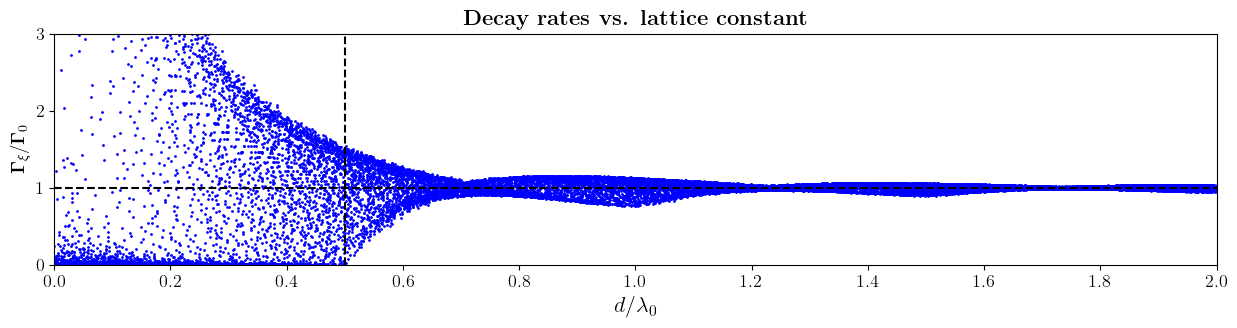

In [23]:

N=50
mhu0=1
c=1
d_value=1
hbar=1
epsilon0=1/(mhu0*c**2)

gamma0 = 1
lambda0=2*np.pi
distances = np.arange(0.00001*np.pi, 4*np.pi, 0.01*np.pi)
#print(distances)
k0=1
omega0=1

atoms = np.zeros((N, 3))
decay_rates_dictionary = {}

for distance in distances:
    for i in range(N):
        atoms[i, 2] = i * distance*k0
    r = [atoms[i] for i in range(N)]
    r_T = [i.reshape(-1, 1) for i in r]

    d=np.array([0,0,d_value])
    d_abs=np.linalg.norm(d)
    d = d.reshape(-1, 1)
    d_T=d.reshape(1, -1)

    def G0(rij,k0): 
        r0=np.linalg.norm(rij)
        rij_T = rij.reshape(-1, 1)
        return ((3*np.pi*k0*np.exp(1j*k0*r0))/(4*np.pi*(k0*r0)**3))*((k0**2*r0**2+1j*k0*r0-1)*np.identity(3)+((-k0**2*r0**2-3j*k0*r0+3)*(np.dot(rij,rij_T)/r0**2)))

    def gamma0_alpha(omega0, d,r0,k0,d_T,epsilon0,hbar,c):
        alpha=3/2*1/(k0**3*r0**3)
        return omega0**3*np.dot(d_T,d)/(3*np.pi*epsilon0*hbar*c**3)*alpha

    def H_eff(r, omega0, mhu0, d, N):
        Matrix = np.zeros((N, N), dtype=complex)
        k0=1
        for i in range(N):
            for j in range(N):
                if i == j:
                    Matrix[i, j] += -1j*gamma0/2
                else:
                    rij = r[i] - r[j]
                    Matrix[i, j] += -np.dot(d_T, np.dot(G0(rij,k0), d))
        return  Matrix

    H_eff_matrix = H_eff(r, omega0, mhu0, d, N)
    eigenvalues = np.imag(np.linalg.eigvals(H_eff_matrix))
    H_eff_imag_eigenvalues_sorted = np.sort(eigenvalues)
    print(f"d/lambda0= {distance/lambda0}",H_eff_imag_eigenvalues_sorted)
    decay_rates_dictionary[distance]=np.abs((2*H_eff_imag_eigenvalues_sorted/-1j*gamma0))
    

plt.figure()

plt.figure(figsize=(15, 3)) 
for distance, decay_rates in decay_rates_dictionary.items():
    lattice_constant = distance / lambda0
    jitter = np.random.normal(0, 0.01, size=len(decay_rates))
    plt.scatter(lattice_constant + jitter, decay_rates, s=1, color='blue')
    #print(f"Max decay rate for distance {distance}: {np.max(decay_rates)}")

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

plt.title(r'\textbf{Decay rates vs. lattice constant}', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel(r'$d / \lambda_{0}$', fontsize=16)
plt.ylabel(r'$\mathbf{\Gamma}_{\xi} / \mathbf{\Gamma}_{0}$', fontsize=14)


plt.axhline(y=1, color='black', linestyle='--')
plt.axvline(x=0.5, color='black', linestyle='--')
plt.ylim([0, 3])
plt.xlim([0, 2])
plt.yticks(np.arange(0, 3.0001, 1))
plt.xticks(np.arange(min(distances/lambda0), max(distances/lambda0)+0.2, 0.2))

plt.show()

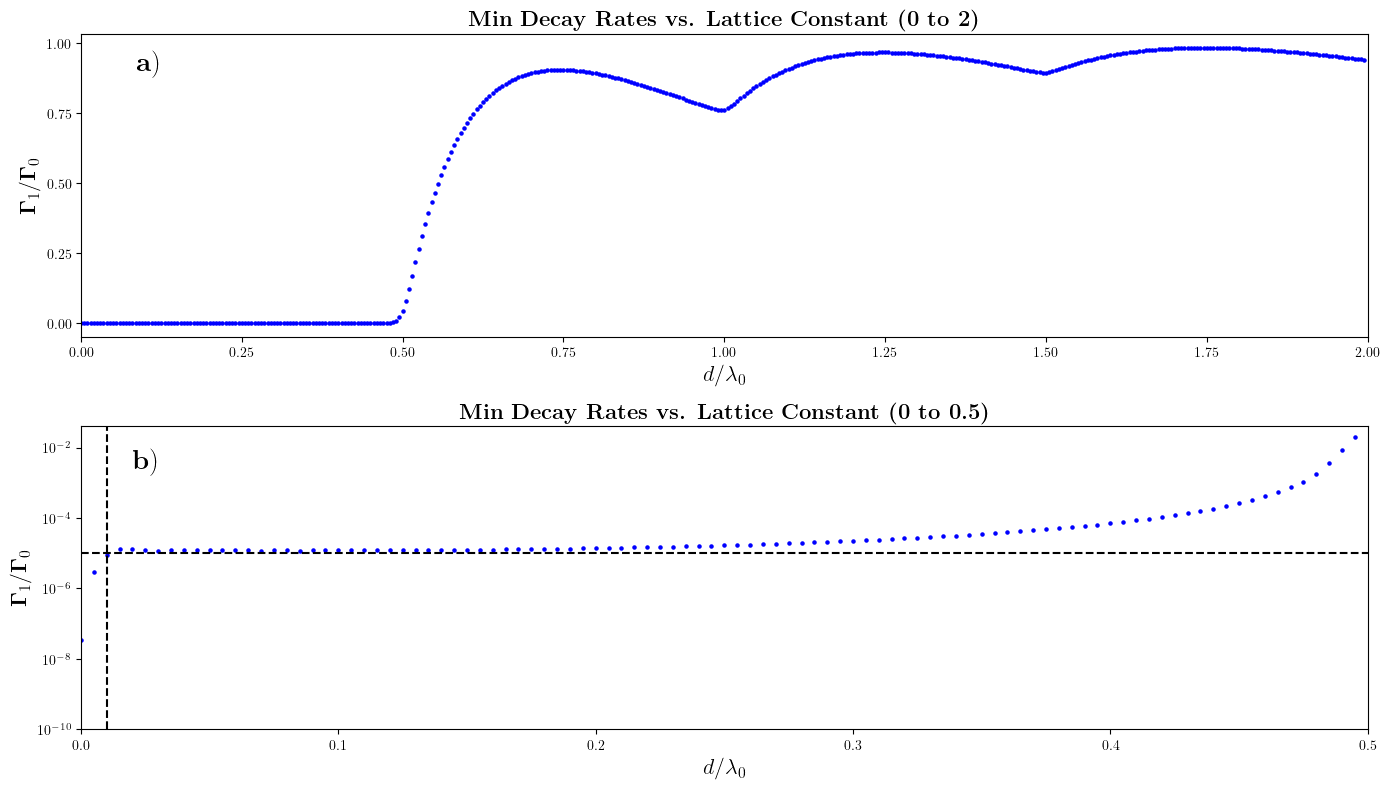

In [36]:

x_values_full_range = []
y_values_full_range = []
x_values_focused_range = []
y_values_focused_range = []
x_values_exp_range = []
y_values_exp_range = []

for distance, decay_rates in decay_rates_dictionary.items():
    min_decay_rate = np.min(decay_rates) 
    lattice_constant = distance / lambda0
    if lattice_constant <= 2:
        x_values_full_range.append(lattice_constant)
        y_values_full_range.append(min_decay_rate)
    if lattice_constant <= 0.5:
        x_values_focused_range.append(lattice_constant)
        y_values_focused_range.append(min_decay_rate)




fig, (ax1, ax2,) = plt.subplots(2, 1, figsize=(14, 8))

# Erster Subplot für den gesamten Bereich
ax1.scatter(x_values_full_range, y_values_full_range, color='blue', s=5)
ax1.set_title(r'\textbf{Min Decay Rates vs. Lattice Constant (0 to 2)}', fontsize=16)
ax1.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax1.set_ylabel(r'$\mathbf{\Gamma}_{1} / \mathbf{\Gamma}_{0}$', fontsize=16)
ax1.set_xlim([0, 2])
ax1.text(0.085, 0.975,r'$\mathbf{a)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax1.set_yticks(np.arange(0, 1.0001, 0.25))

# Zweiter Subplot für den fokussierten Bereich
ax2.scatter(x_values_focused_range, y_values_focused_range, color='blue', s=5)
ax2.set_title(r'\textbf{Min Decay Rates vs. Lattice Constant (0 to 0.5)}', fontsize=16)
ax2.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax2.set_ylabel(r'$\mathbf{\Gamma}_{1} / \mathbf{\Gamma}_{0}$', fontsize=16)
ax2.set_xlim([0, 0.5])
ax2.set_yscale('log')
ax2.set_yticks(np.logspace(-2, -10, num=5))
ax2.text(0.02, 10**-2, r'$\mathbf{b)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax2.axhline(y=10**(-5), color='black', linestyle='--')
ax2.axvline(x=0.01, color='black', linestyle='--')


plt.tight_layout()
plt.show()



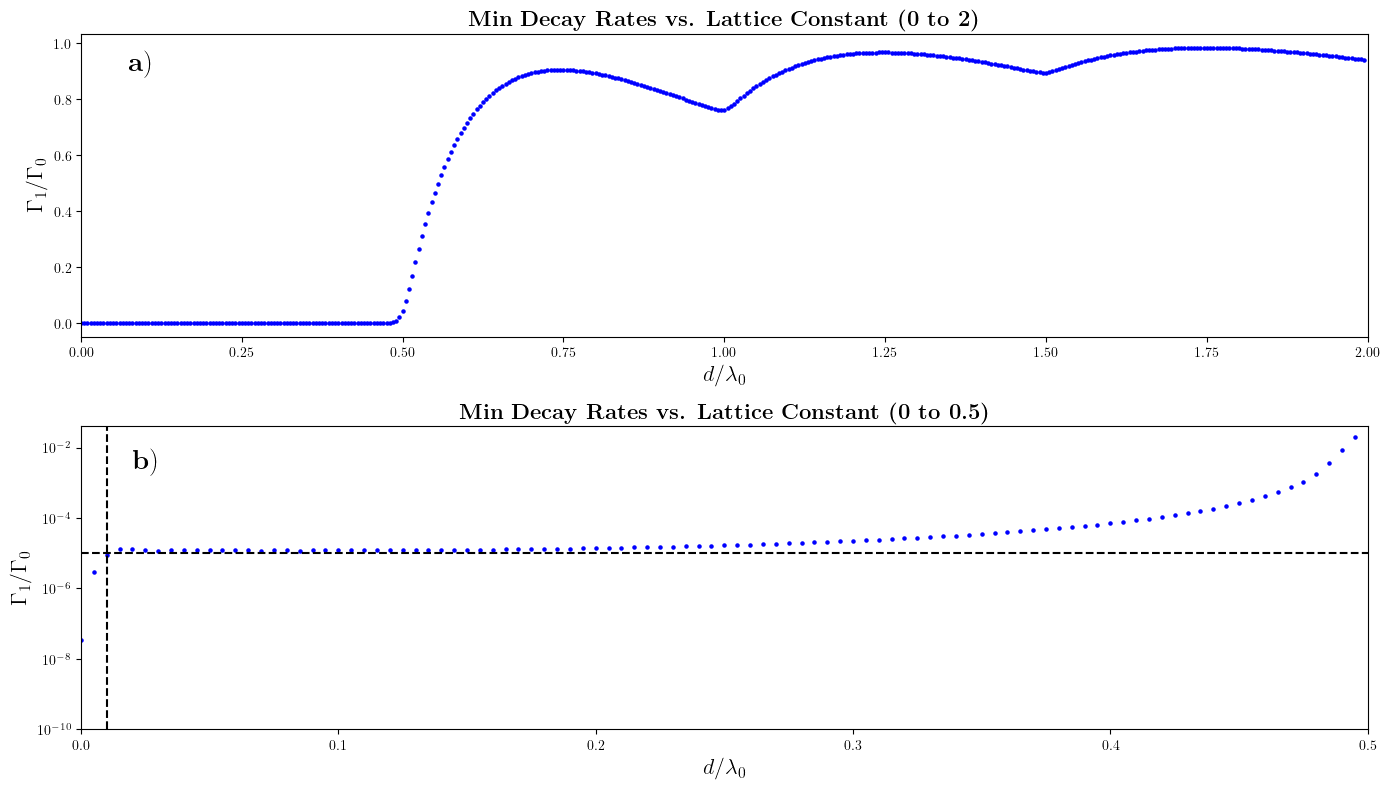

Sorted decay rates for the focused range (0 to 0.5):
[3.428381730943792e-08, 2.9455421278428393e-06, 8.923193503163068e-06, 1.1865116928211646e-05, 1.1987423444407433e-05, 1.1990988258947702e-05, 1.1995700739440804e-05, 1.2003874773979792e-05, 1.20054730098822e-05, 1.2049491079673426e-05, 1.206099600591309e-05, 1.2061918319959735e-05, 1.2072705564652906e-05, 1.2078757462251188e-05, 1.2081464976414807e-05, 1.2082175007226225e-05, 1.2090182376144976e-05, 1.2160089172993922e-05, 1.2163347067419843e-05, 1.2167963409070889e-05, 1.2192406379348139e-05, 1.2201191434050622e-05, 1.2270905167729142e-05, 1.2324645041169791e-05, 1.236388643467658e-05, 1.237752709449444e-05, 1.2415570976520239e-05, 1.2464501262571244e-05, 1.2566618058314958e-05, 1.2683868651155351e-05, 1.2768680822350997e-05, 1.2859960597395546e-05, 1.2868079279405031e-05, 1.2999704815277145e-05, 1.3139472377431392e-05, 1.314976063929857e-05, 1.327452401514656e-05, 1.3413292056449598e-05, 1.3598088090106213e-05, 1.3790568088348186e

In [20]:

x_values_full_range = []
y_values_full_range = []
x_values_focused_range = []
y_values_focused_range = []
x_values_exp_range = []
y_values_exp_range = []

# Collecting data for plotting
for distance, decay_rates in decay_rates_dictionary.items():
    min_decay_rate = np.min(decay_rates)
    lattice_constant = distance / lambda0
    if lattice_constant <= 2:
        x_values_full_range.append(lattice_constant)
        y_values_full_range.append(min_decay_rate)
    if lattice_constant <= 0.5:
        x_values_focused_range.append(lattice_constant)
        y_values_focused_range.append(min_decay_rate)

# Sorting the decay rates for the focused range
sorted_focused_decay_rates = sorted(y_values_focused_range)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Erster Subplot für den gesamten Bereich
ax1.scatter(x_values_full_range, y_values_full_range, color='blue', s=5)
ax1.set_title(r'\textbf{Min Decay Rates vs. Lattice Constant (0 to 2)}', fontsize=16)
ax1.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax1.set_ylabel(r'$\Gamma_{1} / \Gamma_{0}$', fontsize=16)
ax1.set_xlim([0, 2])
ax1.text(0.073, 0.975, r'$\mathbf{a)}$', fontsize=20, fontweight='bold', verticalalignment='top')

# Zweiter Subplot für den fokussierten Bereich
ax2.scatter(x_values_focused_range, y_values_focused_range, color='blue', s=5)
ax2.set_title(r'\textbf{Min Decay Rates vs. Lattice Constant (0 to 0.5)}', fontsize=16)
ax2.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax2.set_ylabel(r'$\Gamma_{1} / \Gamma_{0}$', fontsize=16)
ax2.set_xlim([0, 0.5])
ax2.set_yscale('log')
ax2.set_yticks(np.logspace(-2, -10, num=5))
ax2.text(0.02, 10**-2, r'$\mathbf{b)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax2.axhline(y=10**(-5), color='black', linestyle='--')
ax2.axvline(x=0.01, color='black', linestyle='--')

plt.tight_layout()
plt.show()

# Printing sorted decay rates from the focused range
print("Sorted decay rates for the focused range (0 to 0.5):")
print(sorted_focused_decay_rates)


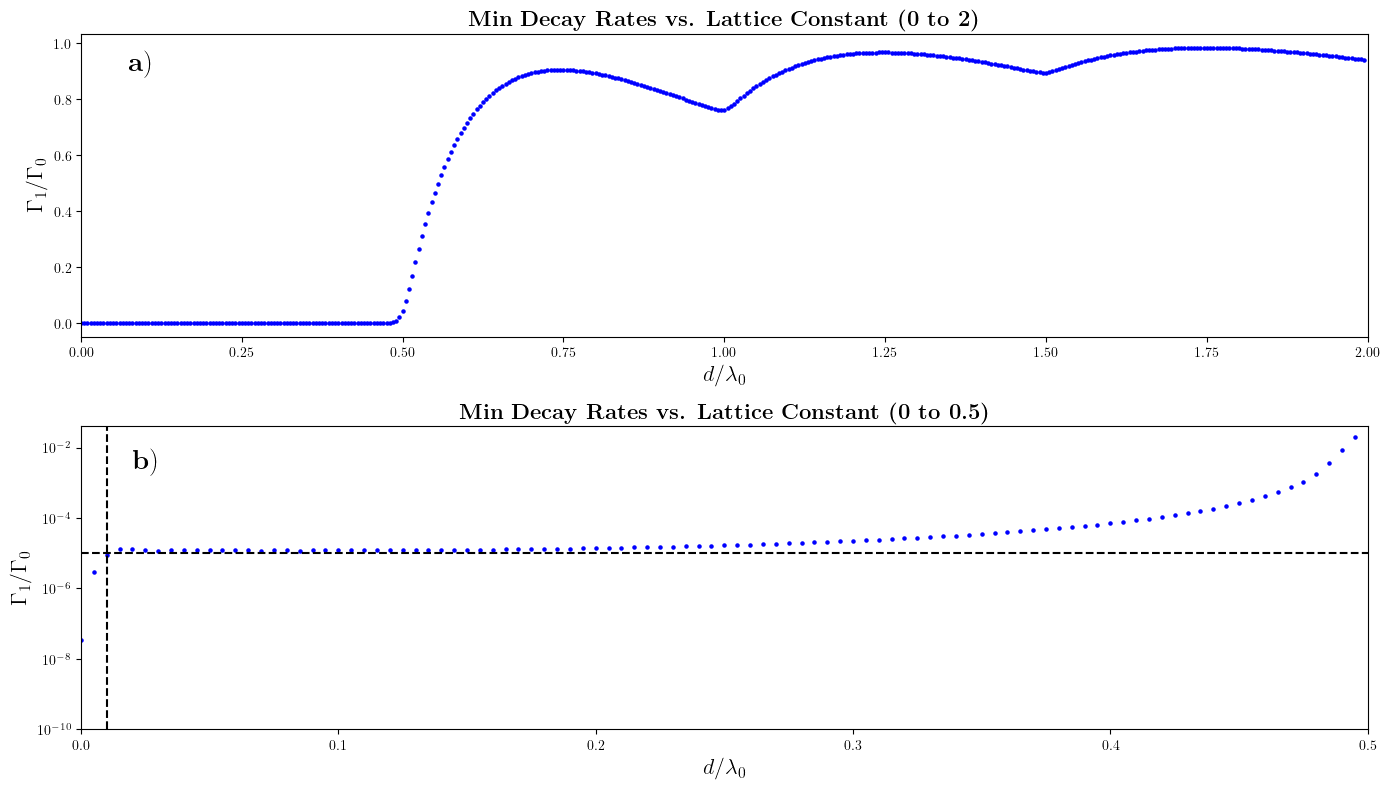

Sorted decay rates for the focused range (0 to 0.5) with corresponding lattice constants:
Lattice constant: 0.00001, Decay rate: 3.42838e-08
Lattice constant: 0.00500, Decay rate: 2.94554e-06
Lattice constant: 0.01001, Decay rate: 8.92319e-06
Lattice constant: 0.01501, Decay rate: 1.28681e-05
Lattice constant: 0.02001, Decay rate: 1.31395e-05
Lattice constant: 0.02501, Decay rate: 1.20610e-05
Lattice constant: 0.03001, Decay rate: 1.18651e-05
Lattice constant: 0.03501, Decay rate: 1.23246e-05
Lattice constant: 0.04000, Decay rate: 1.23775e-05
Lattice constant: 0.04500, Decay rate: 1.20619e-05
Lattice constant: 0.05001, Decay rate: 1.19957e-05
Lattice constant: 0.05501, Decay rate: 1.21633e-05
Lattice constant: 0.06001, Decay rate: 1.21601e-05
Lattice constant: 0.06501, Decay rate: 1.20055e-05
Lattice constant: 0.07001, Decay rate: 1.19874e-05
Lattice constant: 0.07501, Decay rate: 1.20815e-05
Lattice constant: 0.08001, Decay rate: 1.20727e-05
Lattice constant: 0.08501, Decay rate: 1.19

In [21]:


x_values_full_range = []
y_values_full_range = []
x_values_focused_range = []
y_values_focused_range = []

# Collecting data for plotting
for distance, decay_rates in decay_rates_dictionary.items():
    min_decay_rate = np.min(decay_rates)
    lattice_constant = distance / lambda0
    if lattice_constant <= 2:
        x_values_full_range.append(lattice_constant)
        y_values_full_range.append(min_decay_rate)
    if lattice_constant <= 0.5:
        x_values_focused_range.append(lattice_constant)
        y_values_focused_range.append(min_decay_rate)

# Sorting the decay rates for the focused range with corresponding lattice constants
sorted_focused_decay_rates_with_constants = sorted(zip(x_values_focused_range, y_values_focused_range), key=lambda x: x[0])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Erster Subplot für den gesamten Bereich
ax1.scatter(x_values_full_range, y_values_full_range, color='blue', s=5)
ax1.set_title(r'\textbf{Min Decay Rates vs. Lattice Constant (0 to 2)}', fontsize=16)
ax1.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax1.set_ylabel(r'$\Gamma_{1} / \Gamma_{0}$', fontsize=16)
ax1.set_xlim([0, 2])
ax1.text(0.073, 0.975, r'$\mathbf{a)}$', fontsize=20, fontweight='bold', verticalalignment='top')

# Zweiter Subplot für den fokussierten Bereich
ax2.scatter(x_values_focused_range, y_values_focused_range, color='blue', s=5)
ax2.set_title(r'\textbf{Min Decay Rates vs. Lattice Constant (0 to 0.5)}', fontsize=16)
ax2.set_xlabel(r'$d / \lambda_{0}$', fontsize=16)
ax2.set_ylabel(r'$\Gamma_{1} / \Gamma_{0}$', fontsize=16)
ax2.set_xlim([0, 0.5])
ax2.set_yscale('log')
ax2.set_yticks(np.logspace(-2, -10, num=5))
ax2.text(0.02, 10**-2, r'$\mathbf{b)}$', fontsize=20, fontweight='bold', verticalalignment='top')
ax2.axhline(y=10**(-5), color='black', linestyle='--')
ax2.axvline(x=0.01, color='black', linestyle='--')

plt.tight_layout()
plt.show()

# Printing sorted decay rates from the focused range with corresponding lattice constants
print("Sorted decay rates for the focused range (0 to 0.5) with corresponding lattice constants:")
for lattice_constant, decay_rate in sorted_focused_decay_rates_with_constants:
    print(f"Lattice constant: {lattice_constant:.5f}, Decay rate: {decay_rate:.5e}")
